# 프로젝트명 : 나의 첫번째 캐글 경진대회, 무작정 따라하기!

## 프로젝트 루브릭

- 데이터 전처리, 모델학습, 예측의 전체 과정을 거쳐 캐글 submission까지 전과정이 성공적으로 진행되었는가?
- 제출된 노트북이 캐글 커널로 사용될 수 있을 만큼 전처리, 학습, 최적화 진행 과정이 체계적으로 기술되었는가?
- 다양한 피처 엔지니어링과 하이퍼 파라미터 튜닝 등의 최적화 기법을 통해 캐글 리더보드의 Private score 기준 110000 이하의 점수를 얻었는가?

### 시도해볼 수 있는 방법

- 기존에 있는 데이터의 피처를 모델을 보다 잘 표현할 수 있는 형태로 처리하기 (피처 엔지니어링)
- LGBMRegressor, XGBRegressor, RandomForestRegressor 세 가지 이상의 다양한 모델에 대해 하이퍼 파라미터 튜닝하기
- 다양한 하이퍼 파라미터에 대해 그리드 탐색을 시도해서 최적의 조합을 찾아보기
- Baseline 커널에서 활용했던 블렌딩 방법 활용하기
- [이전 대회 상위권 커널 참고해보기]('https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr/notebooks')

## 라이브러리 설치 확인

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.decomposition import PCA
import xgboost as xgb
import lightgbm as lgb


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 데이터 탐색

In [2]:
# 데이터 불러오기
data_dir = os.getenv('HOME')+'/aiffel/exploration/E06/kaggle_kakr_housing/data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

df_train = pd.read_csv(train_data_path)
df_test = pd.read_csv(test_data_path)

In [3]:
print("train_data:", df_train.shape)
print("test_data:", df_test.shape)

train_data: (15035, 21)
test_data: (6468, 20)


### 변수 설명
- pandas의 read_csv 함수를 사용해 데이터를 읽어왔고, 각 변수들이 나타내는 의미를 살펴보겠습니다.
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜  
3. price : 집의 가격(타겟 변수)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 개수(소수점은 세면대, 샤워실, 욕조 등 여부)
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(집을 재건축했다면, 변화가 있을 수 있음)

In [4]:
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

- id : 단순한 index number로 판단됨
- date : yyyymmdd + T000000 형태로 연도, 월을 제외한 나머지 부분을 불필요할 것으로 보임
- bathroom : 정수가 아닌 실수, 소숫점이 있는 경우가 있음(미국 화장실의 기준이 우리나라와 다르다고 함)
- floors : 정수가 아닌 실수, .5로 끝나는 것은 다락방이라고 함
- yr_renovated : 대부분의 값이 0으로 나옴, 0은 재건축을 하지 않은 집을 의미함

### 결측치 확인

<AxesSubplot:>

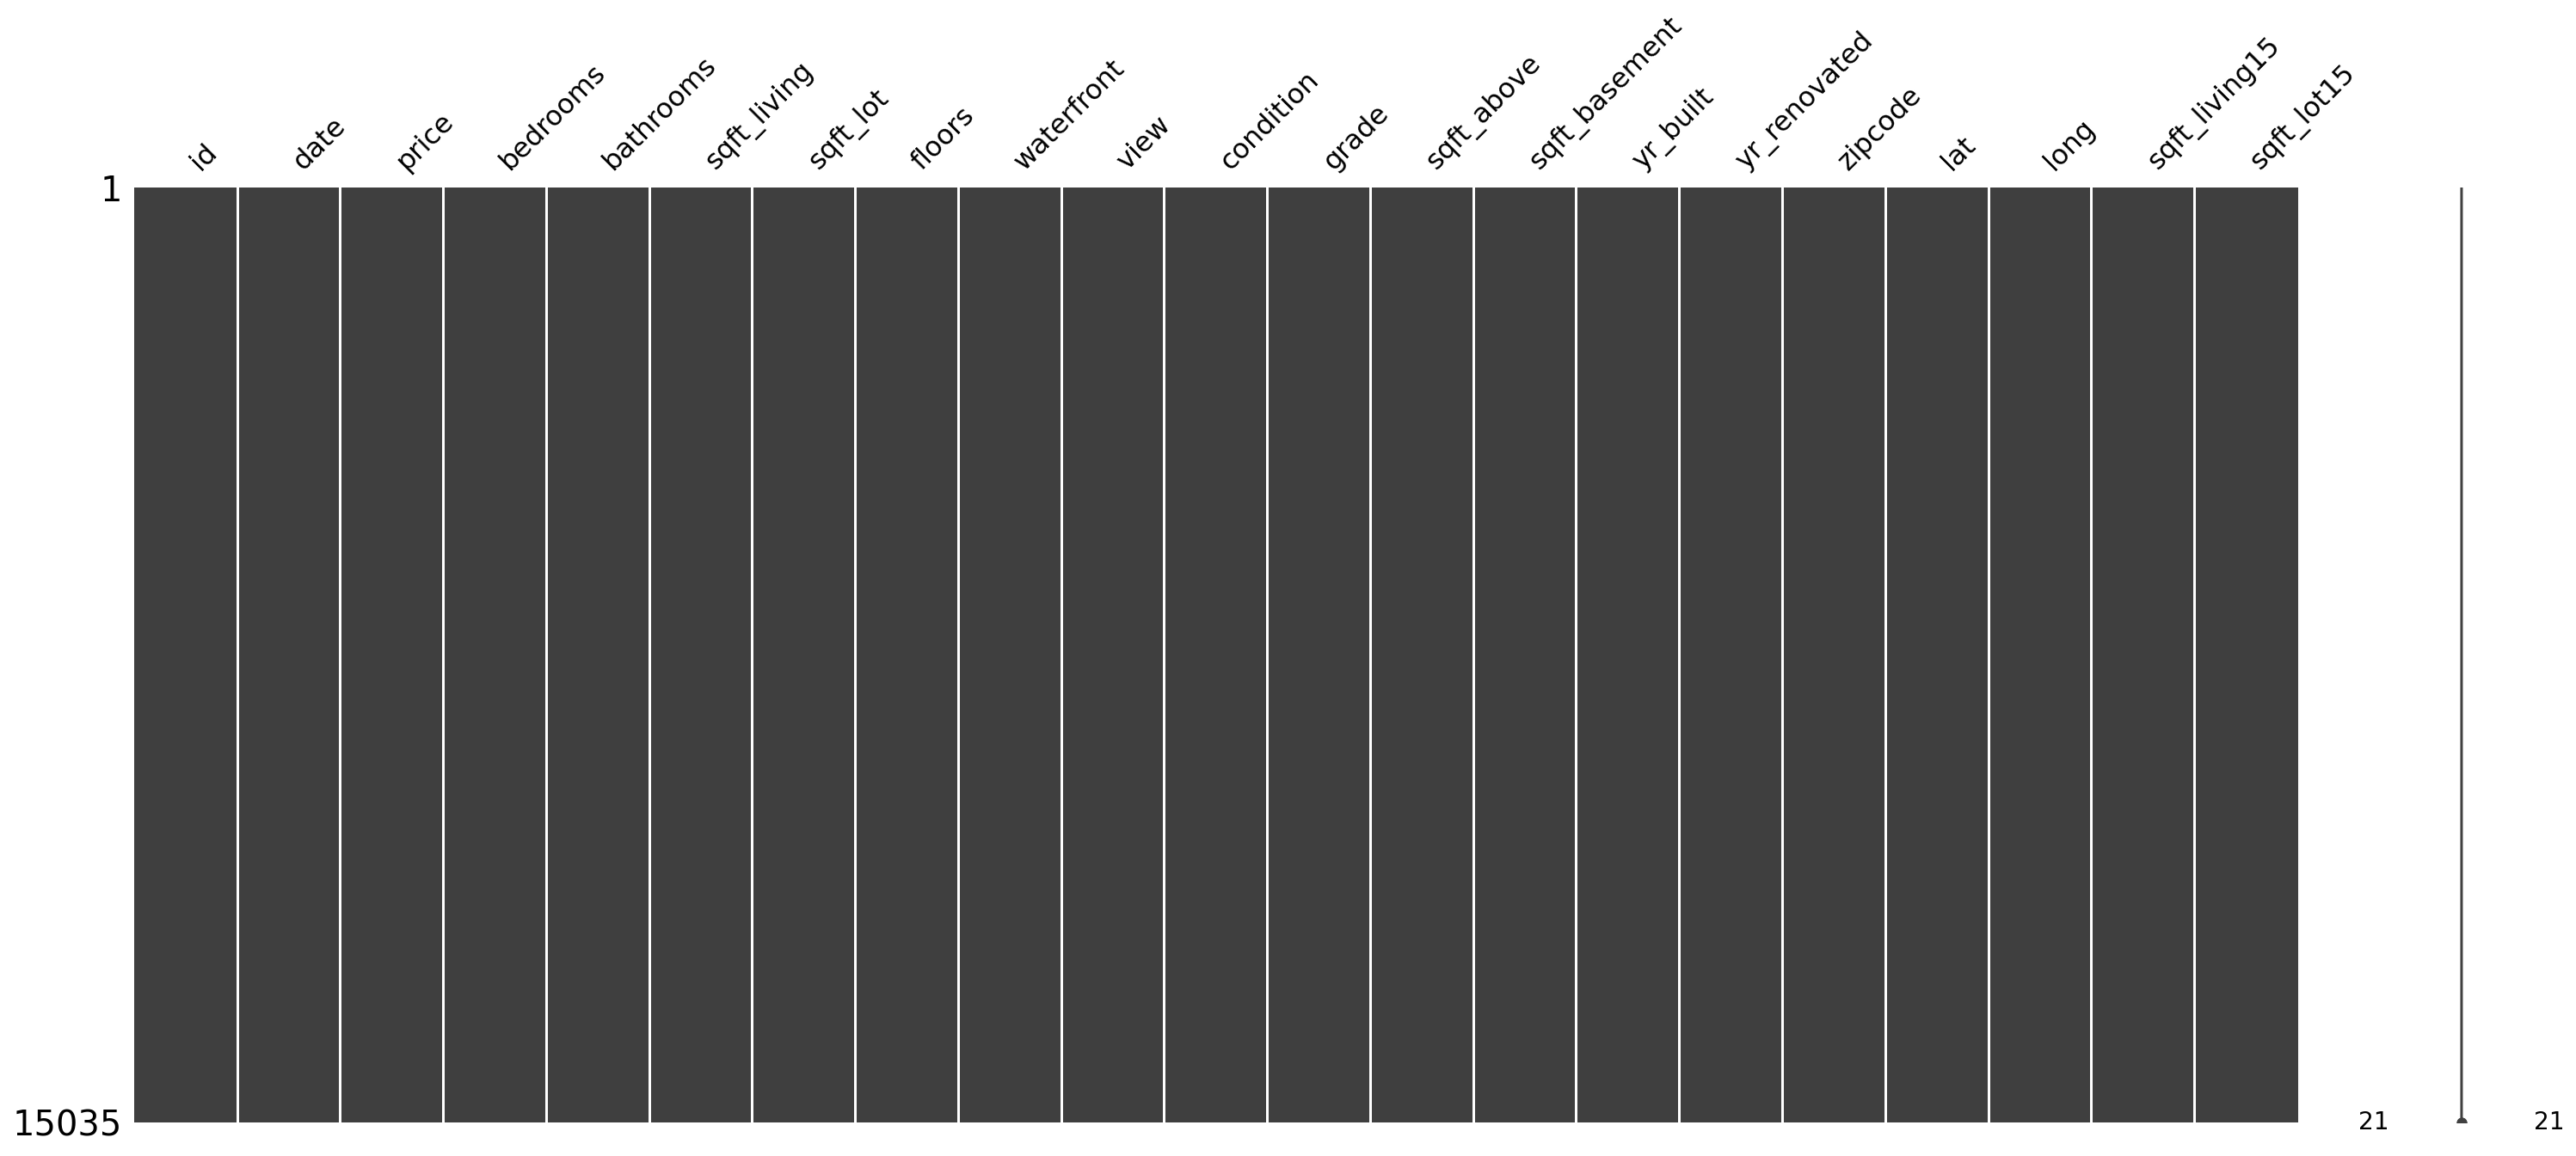

In [6]:
# missingno 라이브러리의 martrix 함수를 사용해 데이터의 결측 상태를 시각화를 통해 살펴 볼 수 있습니다.
# 특정 row, columns에 NaN이라는 결측지가 있다면 해당 부분이 하얗게 나오고, 결측지가 없다면 메트릭스 전체가 까맣게 나옵니다.

# data라는 DataFrame을 매트릭스 모양 그대로 시각화하기
msno.matrix(df_train)

In [7]:
# 결측치 개수 출력
for c in df_train.columns:
    print('{} : {}'.format(c, len(df_train.loc[pd.isnull(df_train[c]), c].values)))

id : 0
date : 0
price : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


## 데이터 시각화

### 타겟 데이터

In [8]:
# price 통계치
df_train['price'].describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

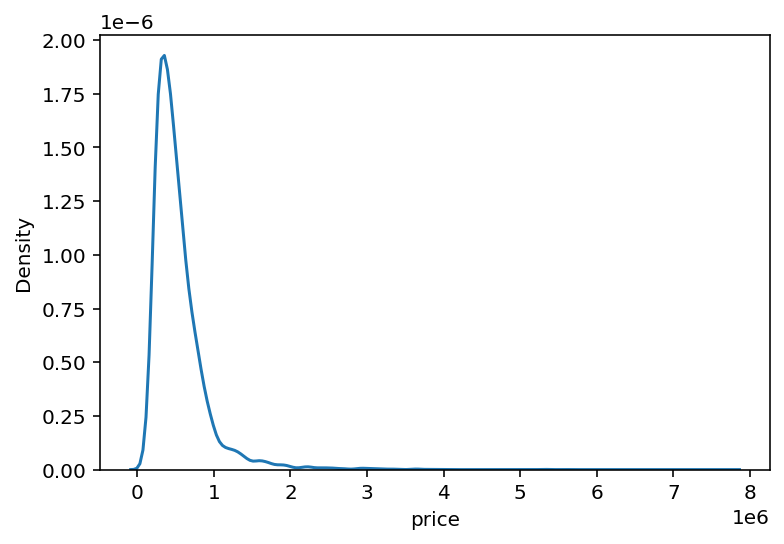

In [9]:
# price의 values들의 분포는?
sns.kdeplot(data=df_train, x='price')
plt.show()  # 한 쪽으로 치우쳐져 있음

회귀 모델을 사용하기 위해 Normalize를 통해 price 분포가 정규분포를 가지도록 만들어 준다.

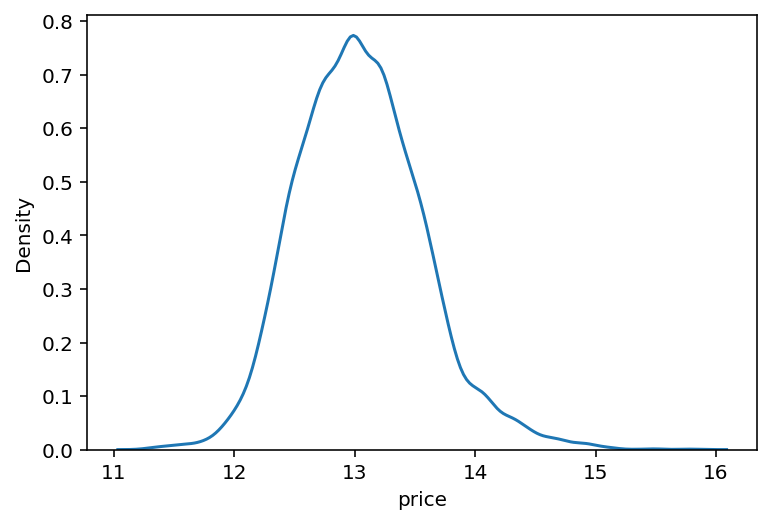

In [10]:
# 로그 변환을 통해 데이텅를 정규분포에 가깝게 만들어 준다.
df_train['price'] = np.log1p(df_train['price'])

sns.kdeplot(data=df_train, x='price')
plt.show()

### 학습 데이터(train data)

피쳐와 라벨 상관관계 확인
- 피어슨 상관관계 : 연속형 변수에 사용
- 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

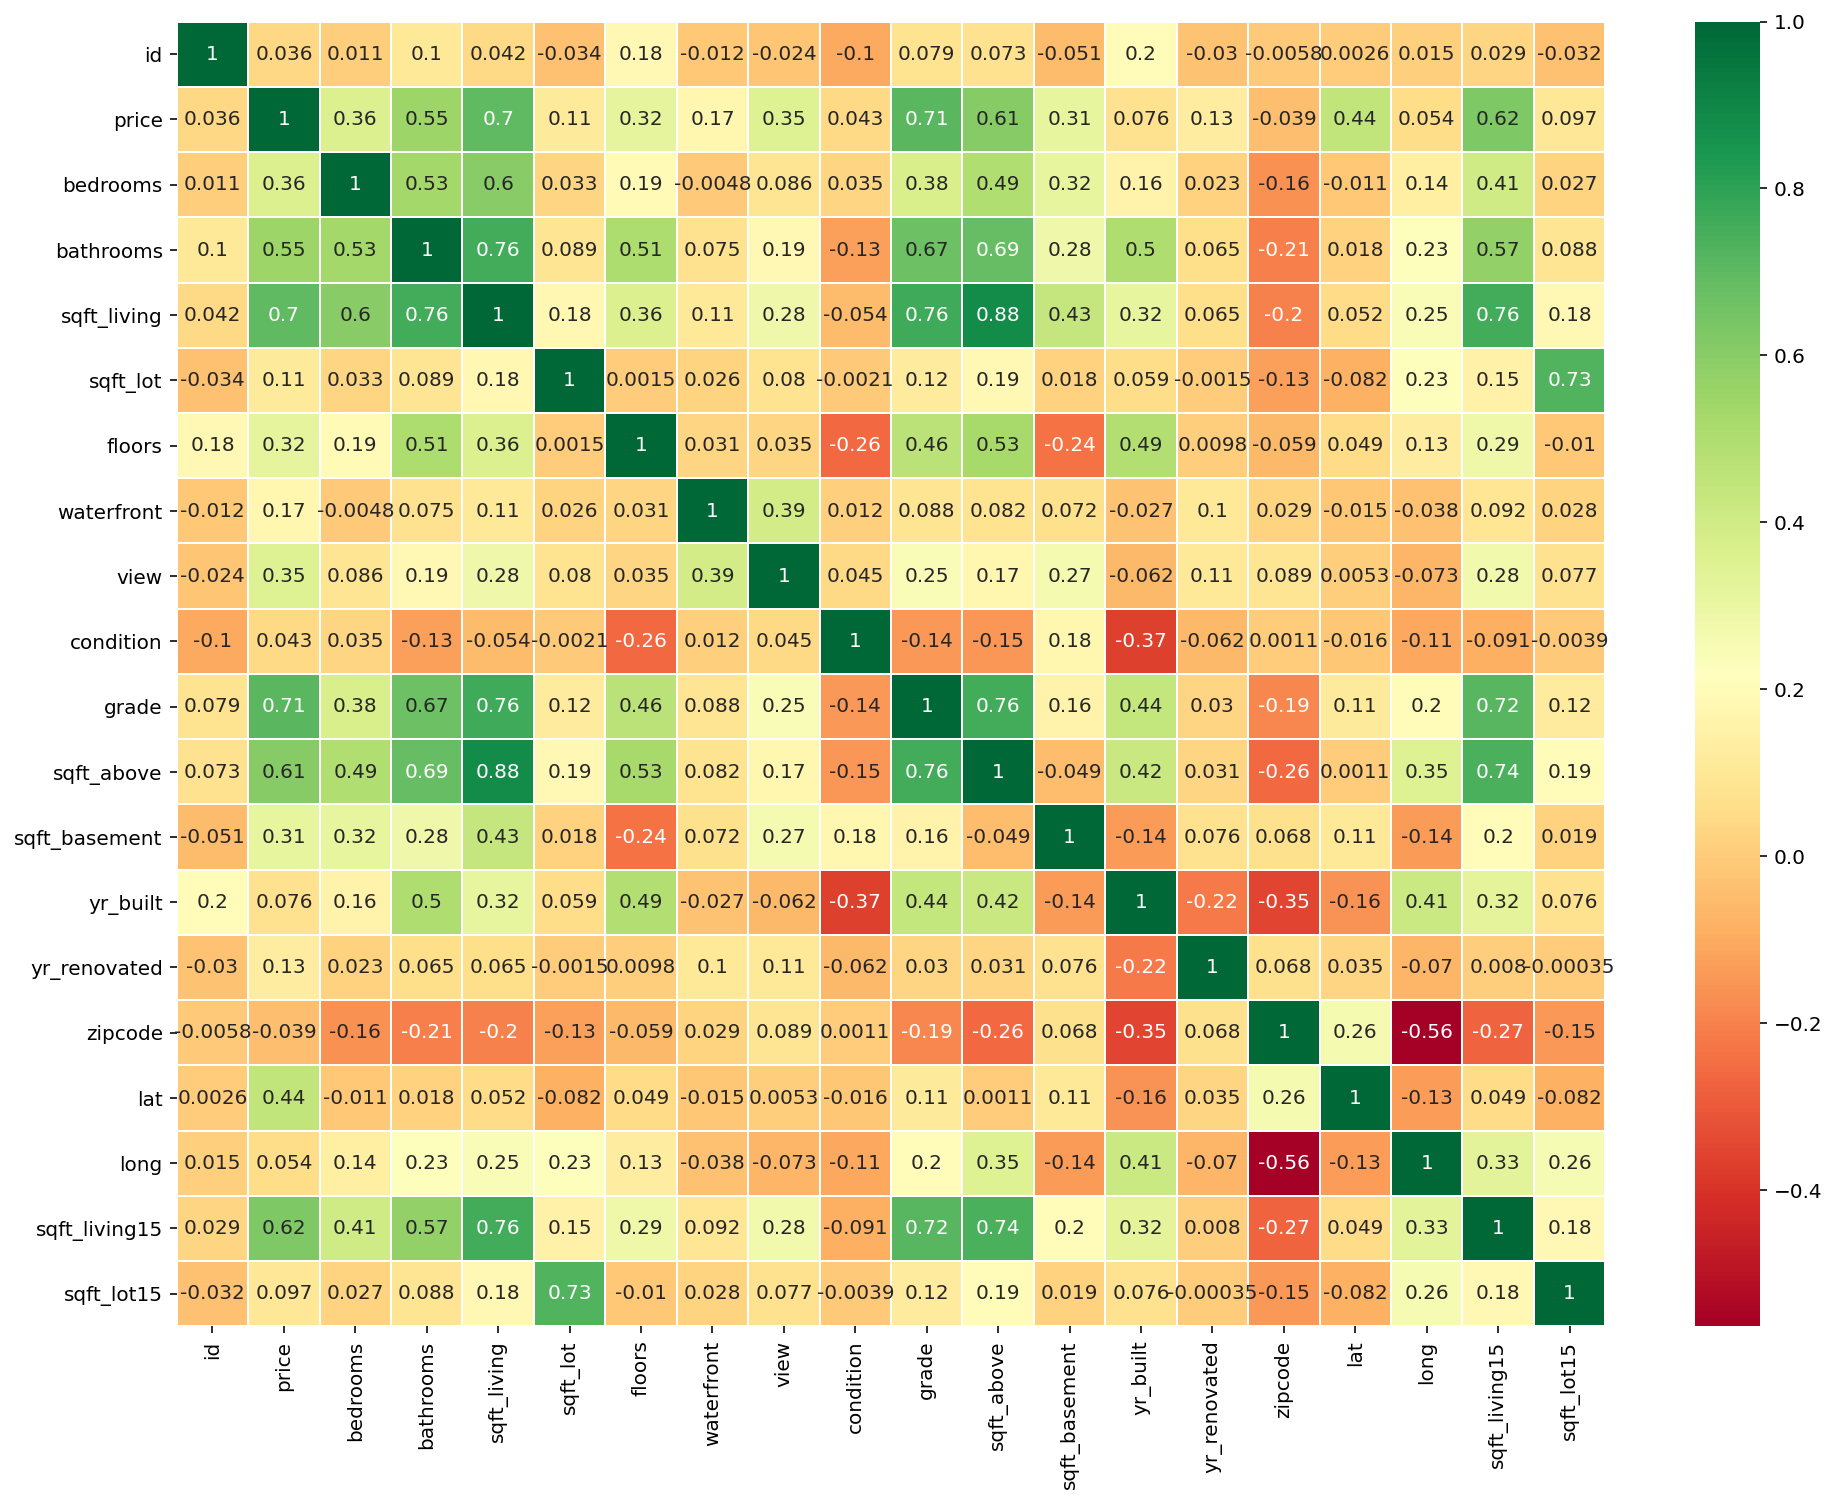

In [11]:
# 상관 관계 확인하기(price vs. other features)
sns.heatmap(df_train.corr(),annot=True, cmap='RdYlGn',linewidths=0.5)
fig = plt.gcf()
fig.set_size_inches(16,12)
plt.show()

__price와 상관관계가 높은 feature (0.3 이상)__
1. grade
2. sqft_living
3. sqft_living 15
4. sqft_above
5. bathroom
6. lat 
7. bedrooms
8. view 
9. floors  

6번의 위도가 price와 상관관계가 높다는 사실을 알게 되었다.

### 데이터 시각화

상관성이 높아 보이는 변수 중심으로 price와 관계를 시각화 해본다.

__grade__

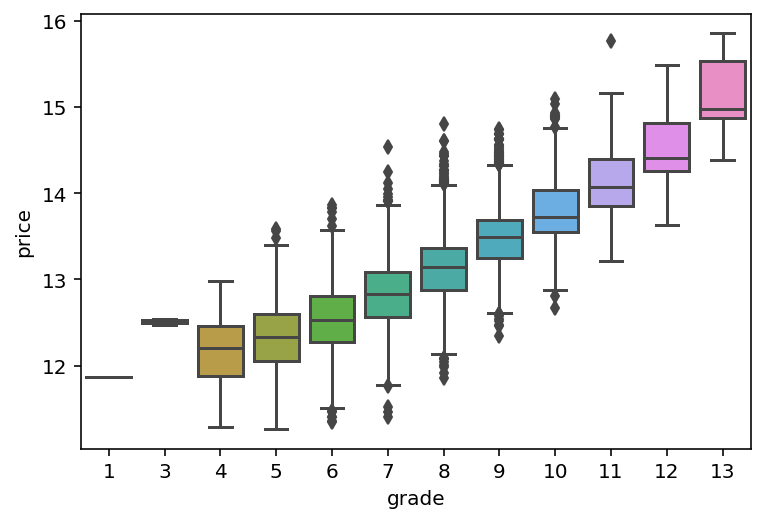

In [12]:
sns.boxplot(data=df_train, x='grade', y='price')
plt.show()

히트맵에서도 상관관계가 높은데 grade의 경우 점수가 높을 수록 집값이 올라간다.  
다음 부분에 대해서는 추가적으로 살펴볼 필요가 있다.
- 등급 3의 경우 값이 큰 이유
- 등급 7~9에서 이상치들이 많은 이유
- 등급 8, 11에서 차이가 큰 이상치가 나타는 이유

__sqft_living__

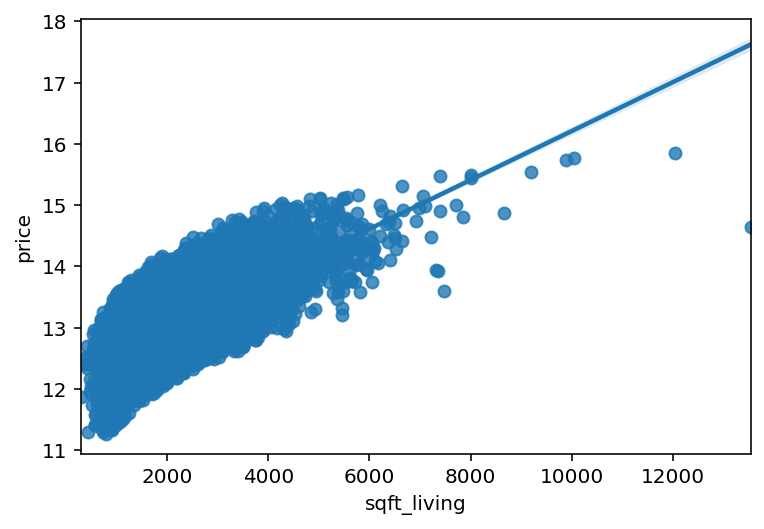

In [13]:
sns.regplot(data=df_train, x='sqft_living', y='price')
plt.show()

전반적으로 선형성을 보이지만 가격이 14~15 사이에 sqft가 14000에 가까운 큰 면적의 집이 있는데 이상치일 수도 있다.

__sqft_living15__

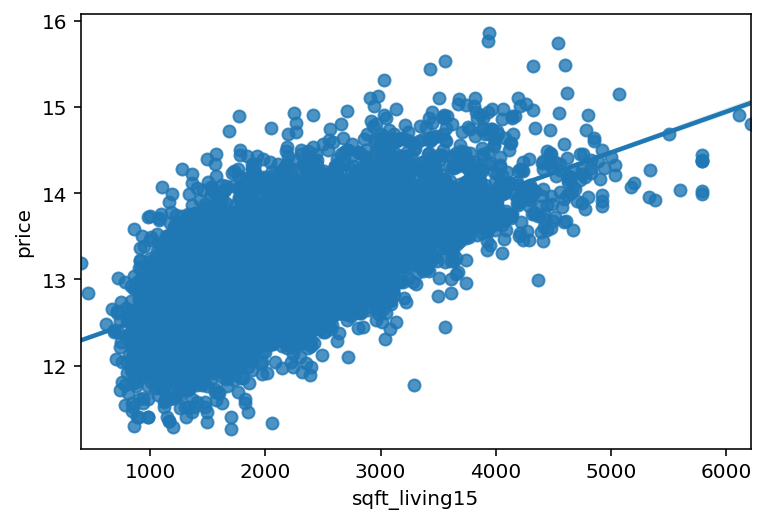

In [14]:
sns.regplot(data=df_train, x='sqft_living15', y='price')
plt.show()

sqft_living15에서 15의 의미는 가장 가까운 15개 집의 면적의 평균이라고 생각하는 게 맞을 것 같다.

In [15]:
df_train['sqft_living_diff'] = df_train['sqft_living15'] - df_train['sqft_living']
df_train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_diff
0,0,20141013T000000,12.309987,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,160
1,1,20150225T000000,12.100718,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,1950
2,2,20150218T000000,13.142168,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,120
3,3,20140627T000000,12.458779,3,2.25,1715,6819,2.0,0,0,...,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,523
4,4,20150115T000000,12.583999,3,1.50,1060,9711,1.0,0,0,...,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,590


__sqft_above__

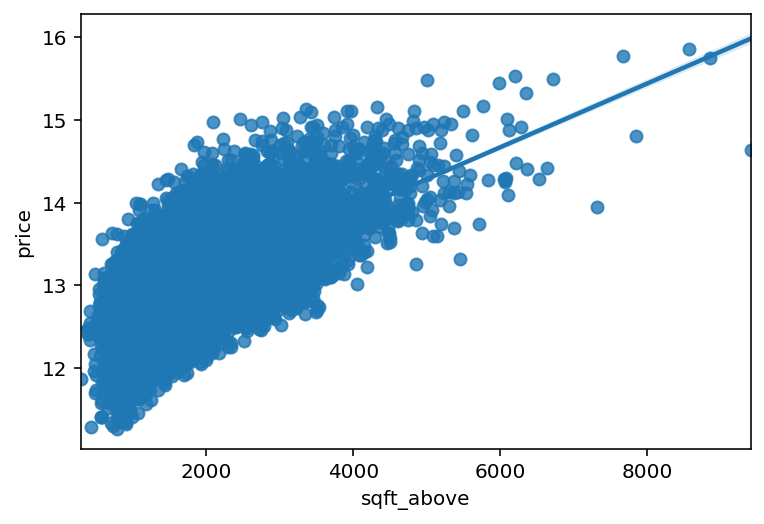

In [16]:
sns.regplot(data=df_train, x='sqft_above', y='price')
plt.show()

sqft_above와 sqft_living의 면적 크기가 차이나는 이유는?

__bathrooms__

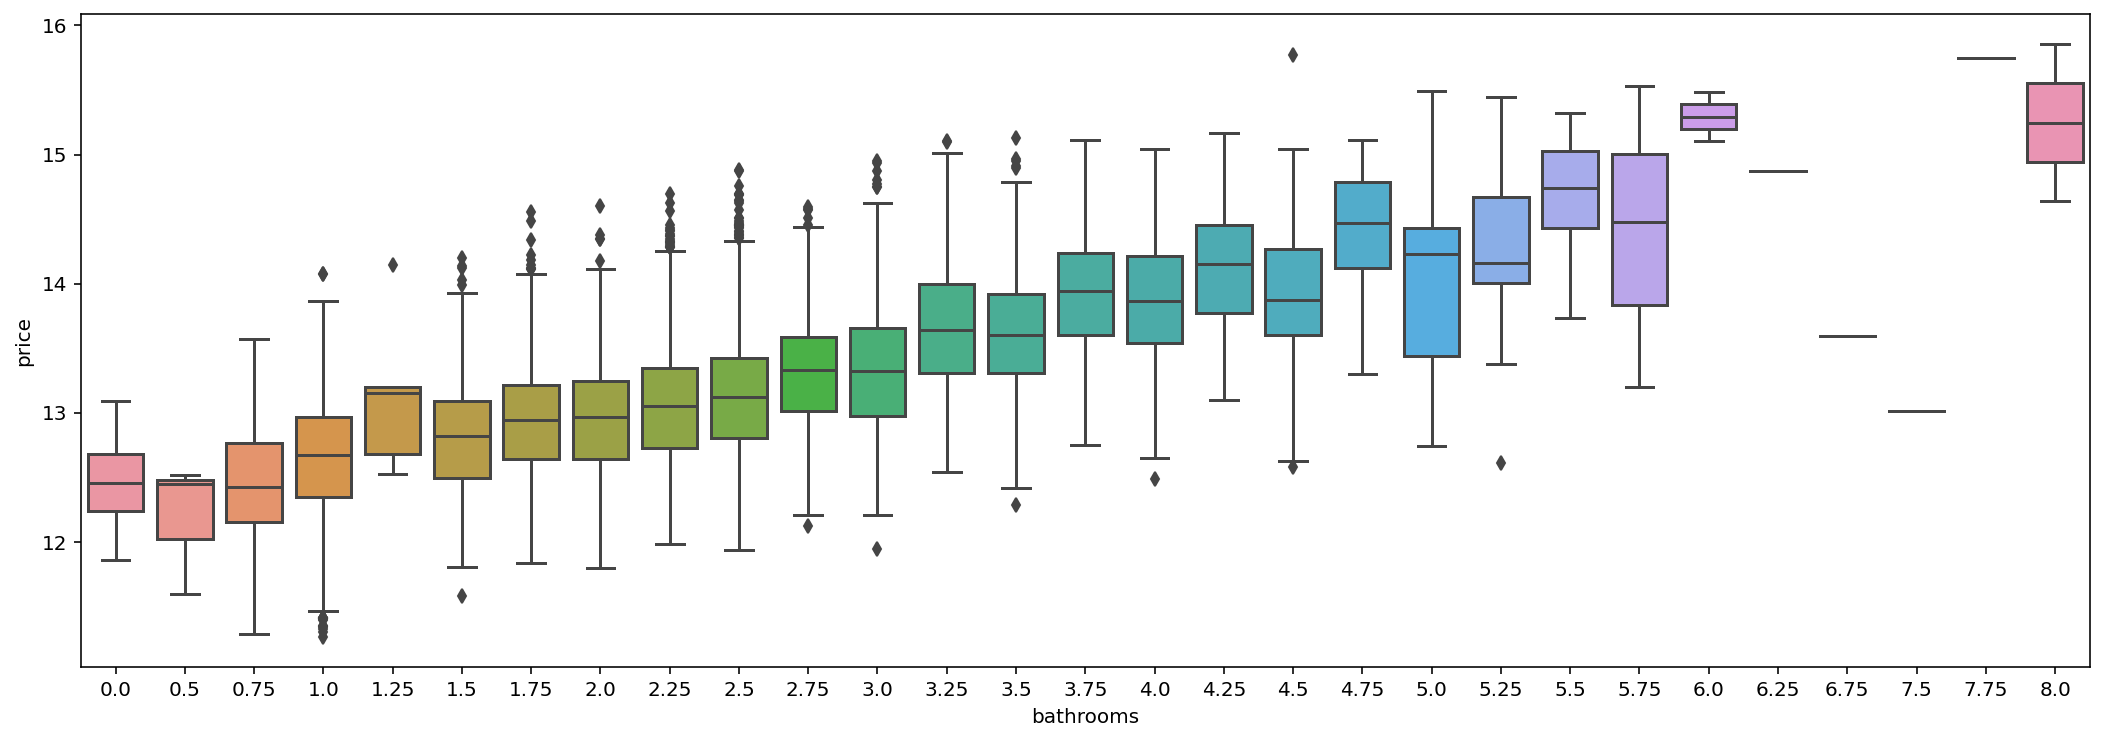

In [17]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_train, x='bathrooms', y='price')
plt.show()

__bedrooms__

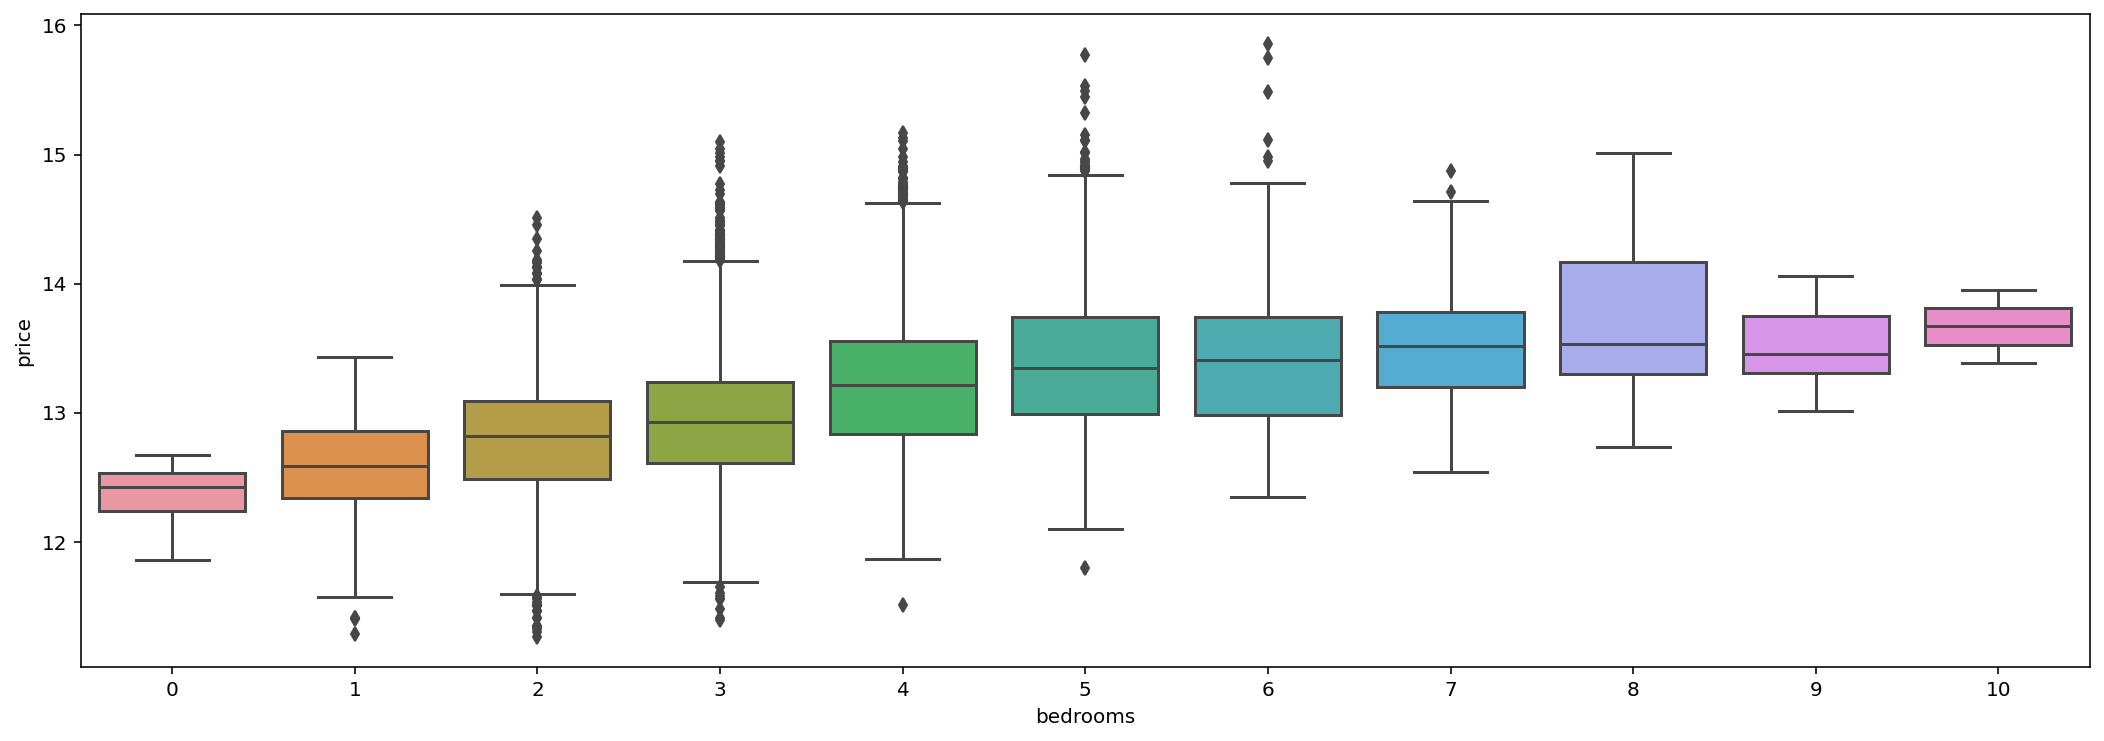

In [18]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_train, x='bedrooms', y='price')
plt.show()

__view__

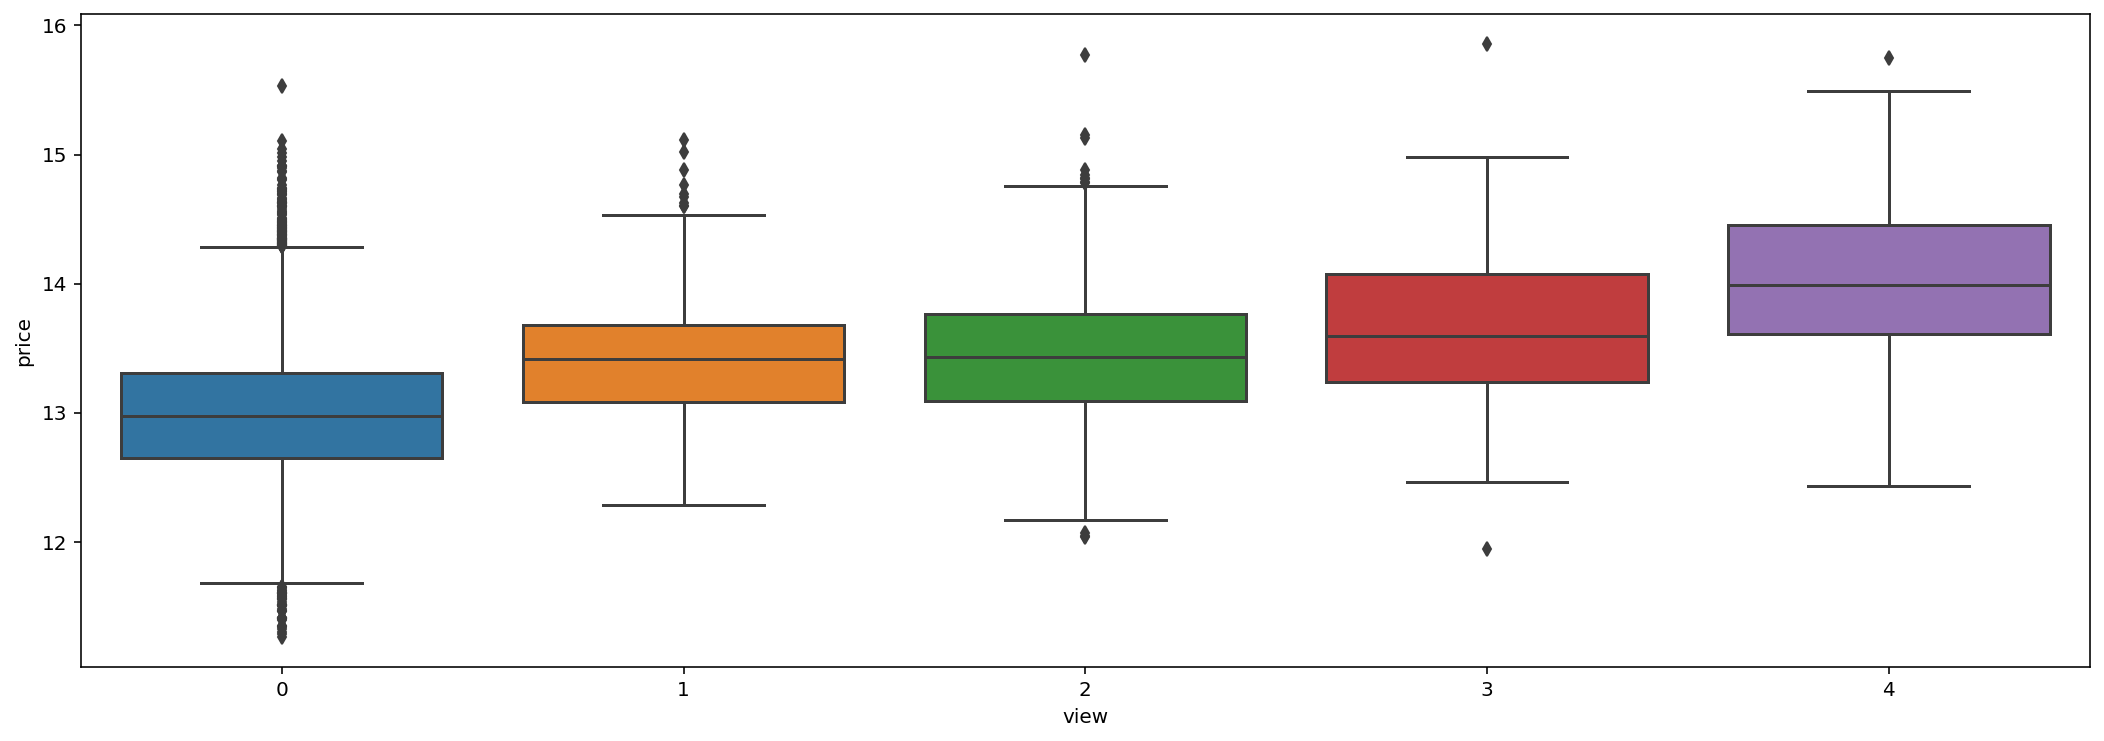

In [19]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_train, x='view', y='price')
plt.show()

view는 집이 얼마나 좋아 보이는지를 의미하는데 점수가 낮은 집(0~1)도 집값이 높게 형성되고 있음을 확인할 수 있다.

__floors__

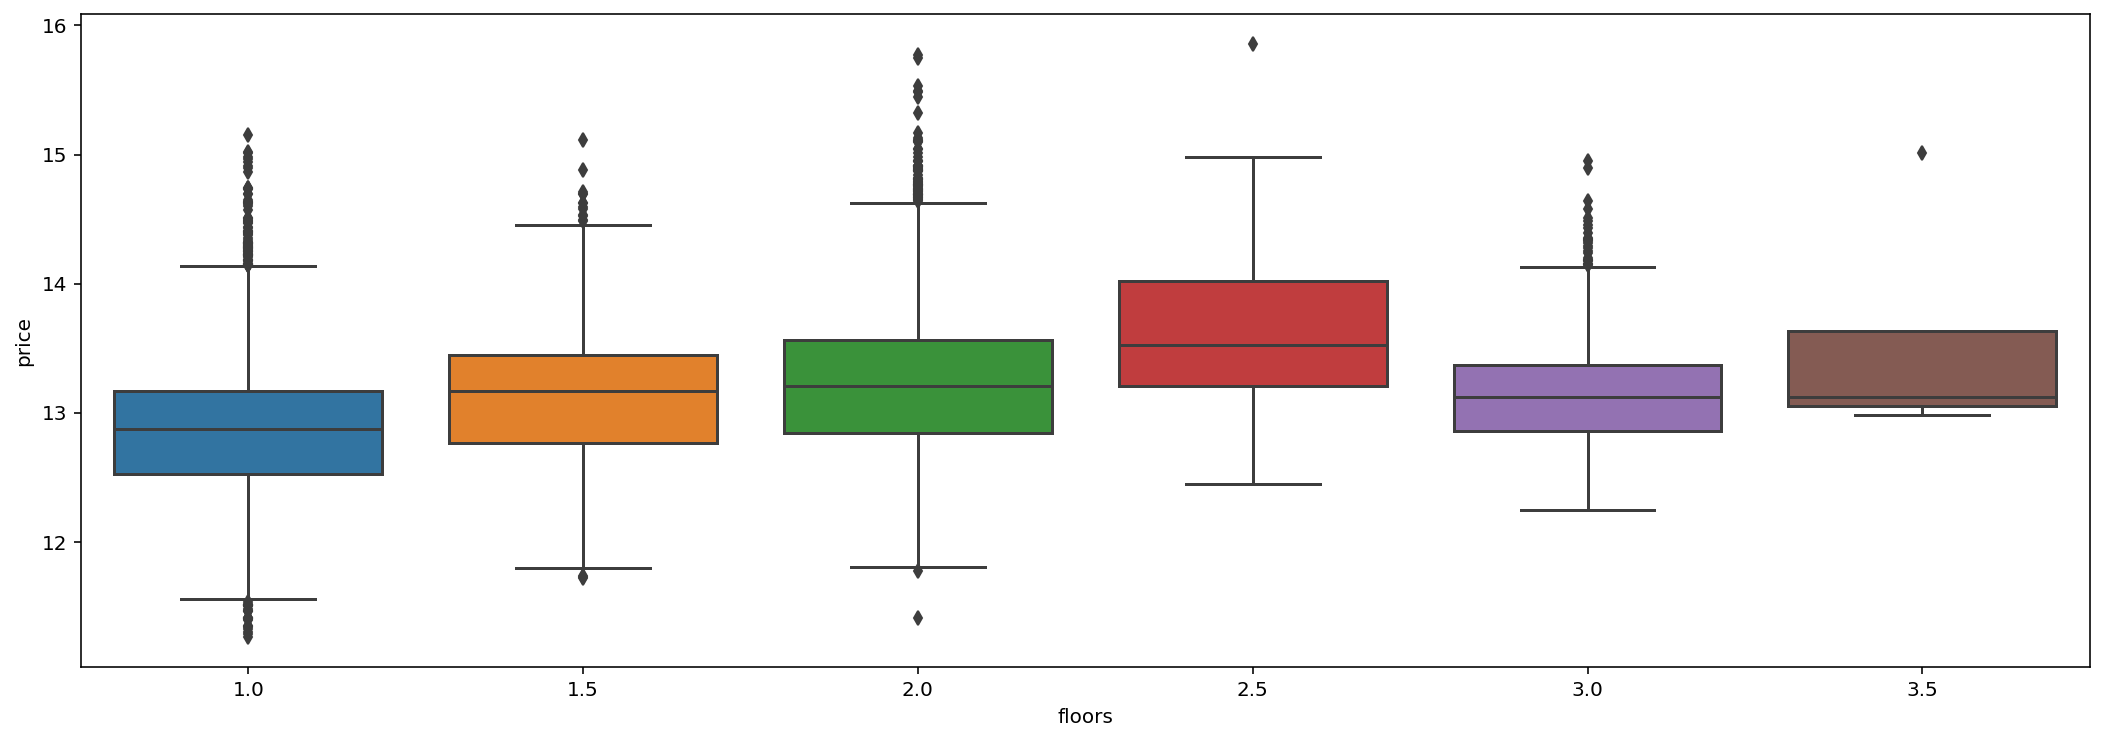

In [20]:
plt.figure(figsize=(18, 6))
sns.boxplot(data=df_train, x='floors', y='price')
plt.show()

bedroom의 median 값을 중심으로 살펴보면 어느 정도 선형 관계를 확인할 수 있다. 그리고 방의 갯수가 2~6개인 경우에도 집값이 높은 집들이 많다. 이는 지역적 특성이 고려되어 부촌 지역으로 예상해볼 수 있을 것 같다.

## 데이터 전처리

### 이상치 제거

__grade__

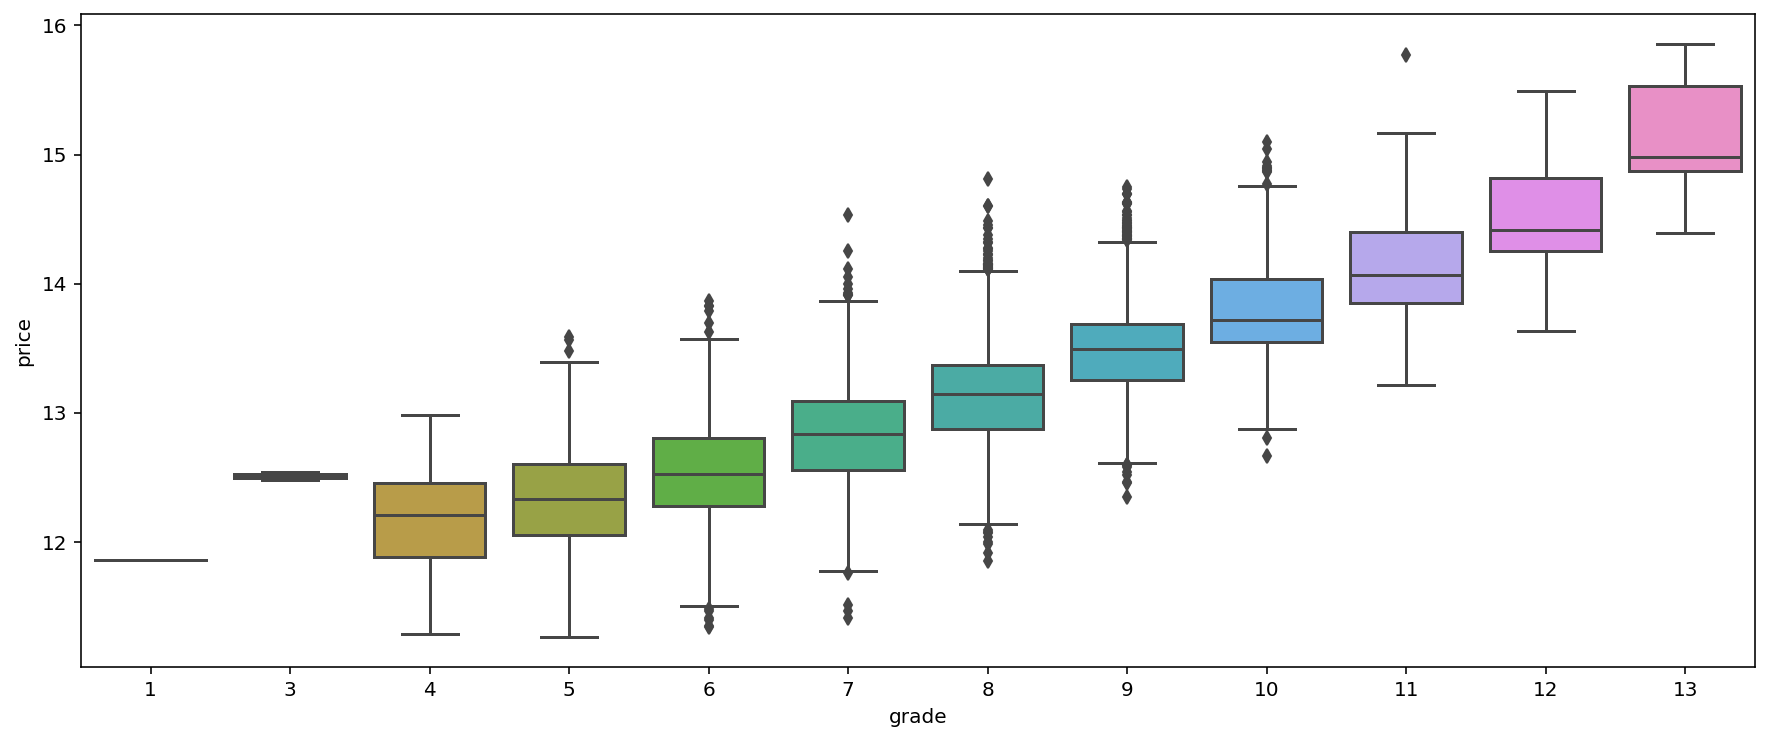

In [21]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df_train, x='grade', y='price')
plt.show()

In [22]:
df_train.loc[(df_train['grade'] == 3) & (df_train['price'] > 12)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_diff
2302,2302,20150225T000000,12.476104,1,0.75,520,12981,1.0,0,0,...,520,0,1920,0,98022,47.2082,-121.995,1340,12233,820
4123,4123,20141104T000000,12.542548,1,0.00,600,24501,1.0,0,0,...,600,0,1950,0,98045,47.5316,-121.749,990,22549,390


In [23]:
df_train.loc[(df_train['grade'] == 11) & (df_train['price'] > 15.5)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_diff
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,...,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449,-6110


In [24]:
df_train = df_train.loc[df_train['id']!=2302]
df_train = df_train.loc[df_train['id']!=4123]
df_train = df_train.loc[df_train['id']!=2775]

__sqft_living__

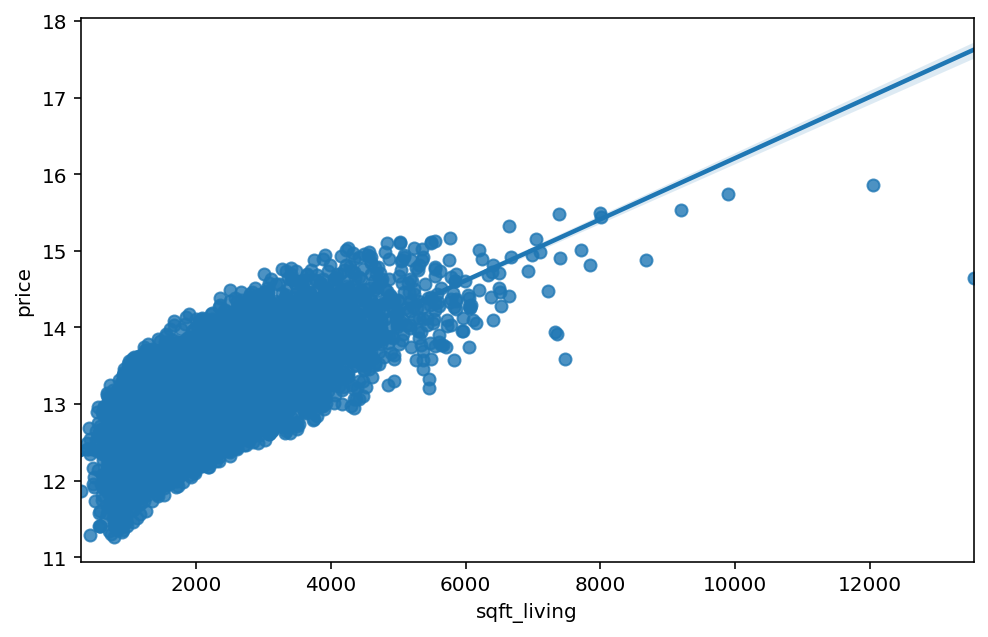

In [25]:
plt.figure(figsize=(8,5))
sns.regplot(data=df_train, x='sqft_living', y='price')
plt.show()

In [26]:
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_diff
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,...,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800,-8690


In [27]:
df_train = df_train.loc[df_train['id']!=8912]

### 기존 변수 제거

In [28]:
# 학습 데이터에서 라벨 제거하기
# price 컬럼은 따로 y라는 변수에 저장 한 후 해당 컬럼은 지워줍니다.
target = df_train['price']
del df_train['price']

print(df_train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqft_living_diff'],
      dtype='object')


In [29]:
# 모델을 학습시키기 전에 전체 데이터에 대해 탐색해보기 위해 학습 데이터와 테스트, 두 데이터를 합칩니다.

# 모델 학습을 진행할 때에는 다시 분리해서 사용해야 하기 때문에 데이터를 합치기 전 
# train_len에 training data의 개수를 저장해서 추후에 학습데이터만 불러올 수 있는 인덱스로 사용
train_len = len(df_train)

# pd.concat()
data = pd.concat((df_train, df_test), axis=0)
print(len(data))

21499


In [30]:
# 필요없는 id 칼럼 제거(단, 제출 시를 대비해 sub_id 변수에 id 칼럼을 지우고 저장해준다.)
sub_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'sqft_living_diff'],
      dtype='object')


In [31]:
# date 컬럼 수정
data['date'] = data['date'].apply(lambda x : str(x[:6])).astype(str) # str(x[:6]) : 연월(yyyymm) 데이터만 잘라내기

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_diff
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,160.0
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,1950.0
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,120.0
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819,523.0
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711,590.0


In [32]:
# yr_renovated 컬럼 수정(재건축 Y : 재건축 연도, 재건축 N : 준공연도 표기)
data['yr_renovated'] = data['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)  
data['yr_renovated'] = data['yr_renovated'].fillna(data['yr_built'])

data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_diff
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,1955.0,98178,47.5112,-122.257,1340,5650,160.0
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,1933.0,98028,47.7379,-122.233,2720,8062,1950.0
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,1987.0,98074,47.6168,-122.045,1800,7503,120.0
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,1995.0,98003,47.3097,-122.327,2238,6819,523.0
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,1963.0,98198,47.4095,-122.315,1650,9711,590.0


### 정규화
한쪽으로 치우친 분포는 모델이 결과를 예측하기에 좋지 않은 영향을 미치므로 다듬어줄 필요가 있습니다.

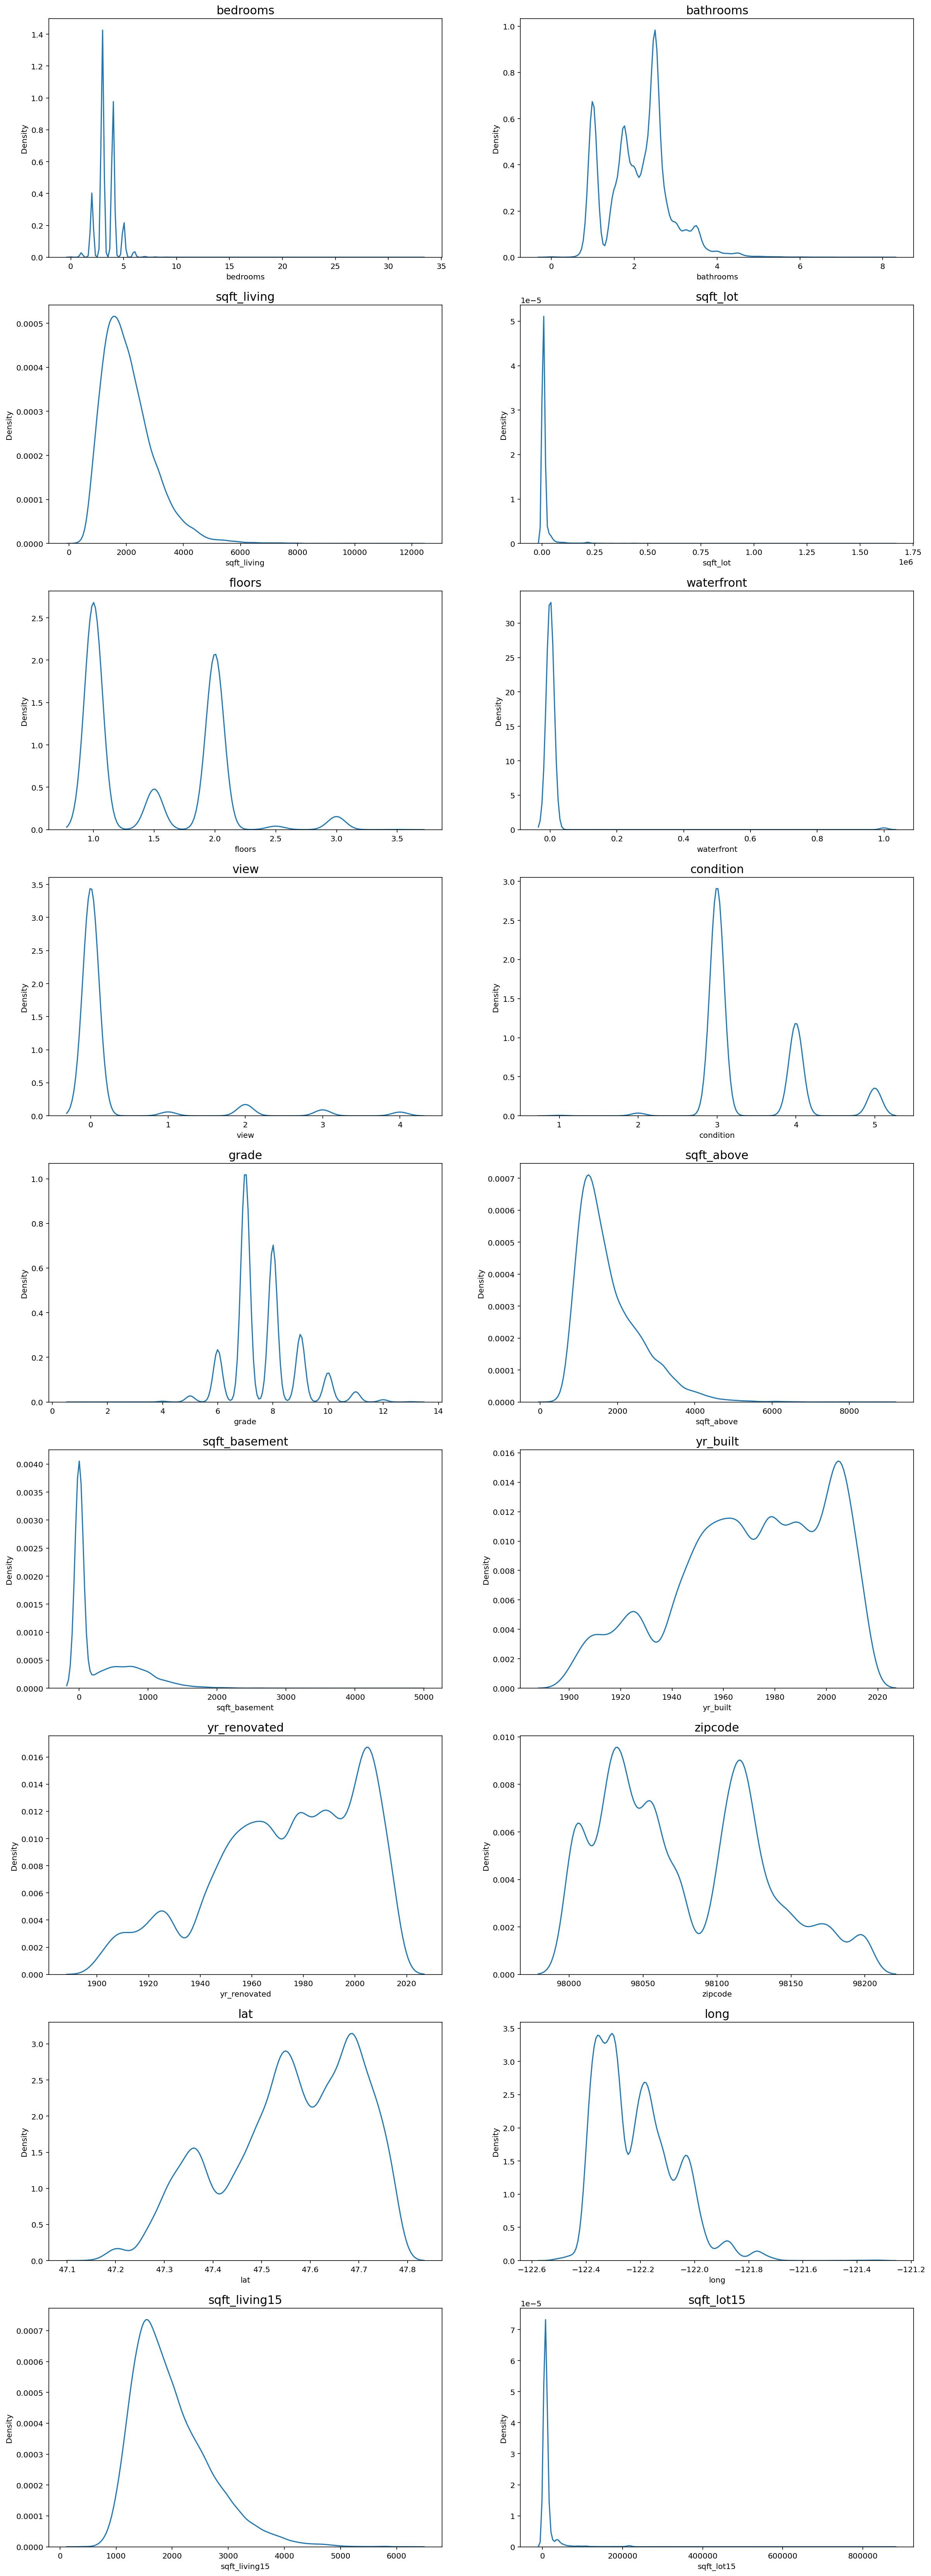

In [33]:
fig, ax = plt.subplots(9, 2, figsize=(20,60))   # 가로스크롤 때문에 그래프 확인이 불편하다면 figsize의 x값을 조절해 보세요. 

# id 변수(count==0인 경우)는 제외하고 분포를 확인합니다.
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count], fontsize=15)
        count += 1
        if count == 19 :
            break

bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보였습니다.<br>
log-scaling을 통해 데이터 분포를 정규분포에 가깝게 만들어 보겠습니다.

In [34]:
# 정규화
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    data[c] = np.log1p(data[c].values)

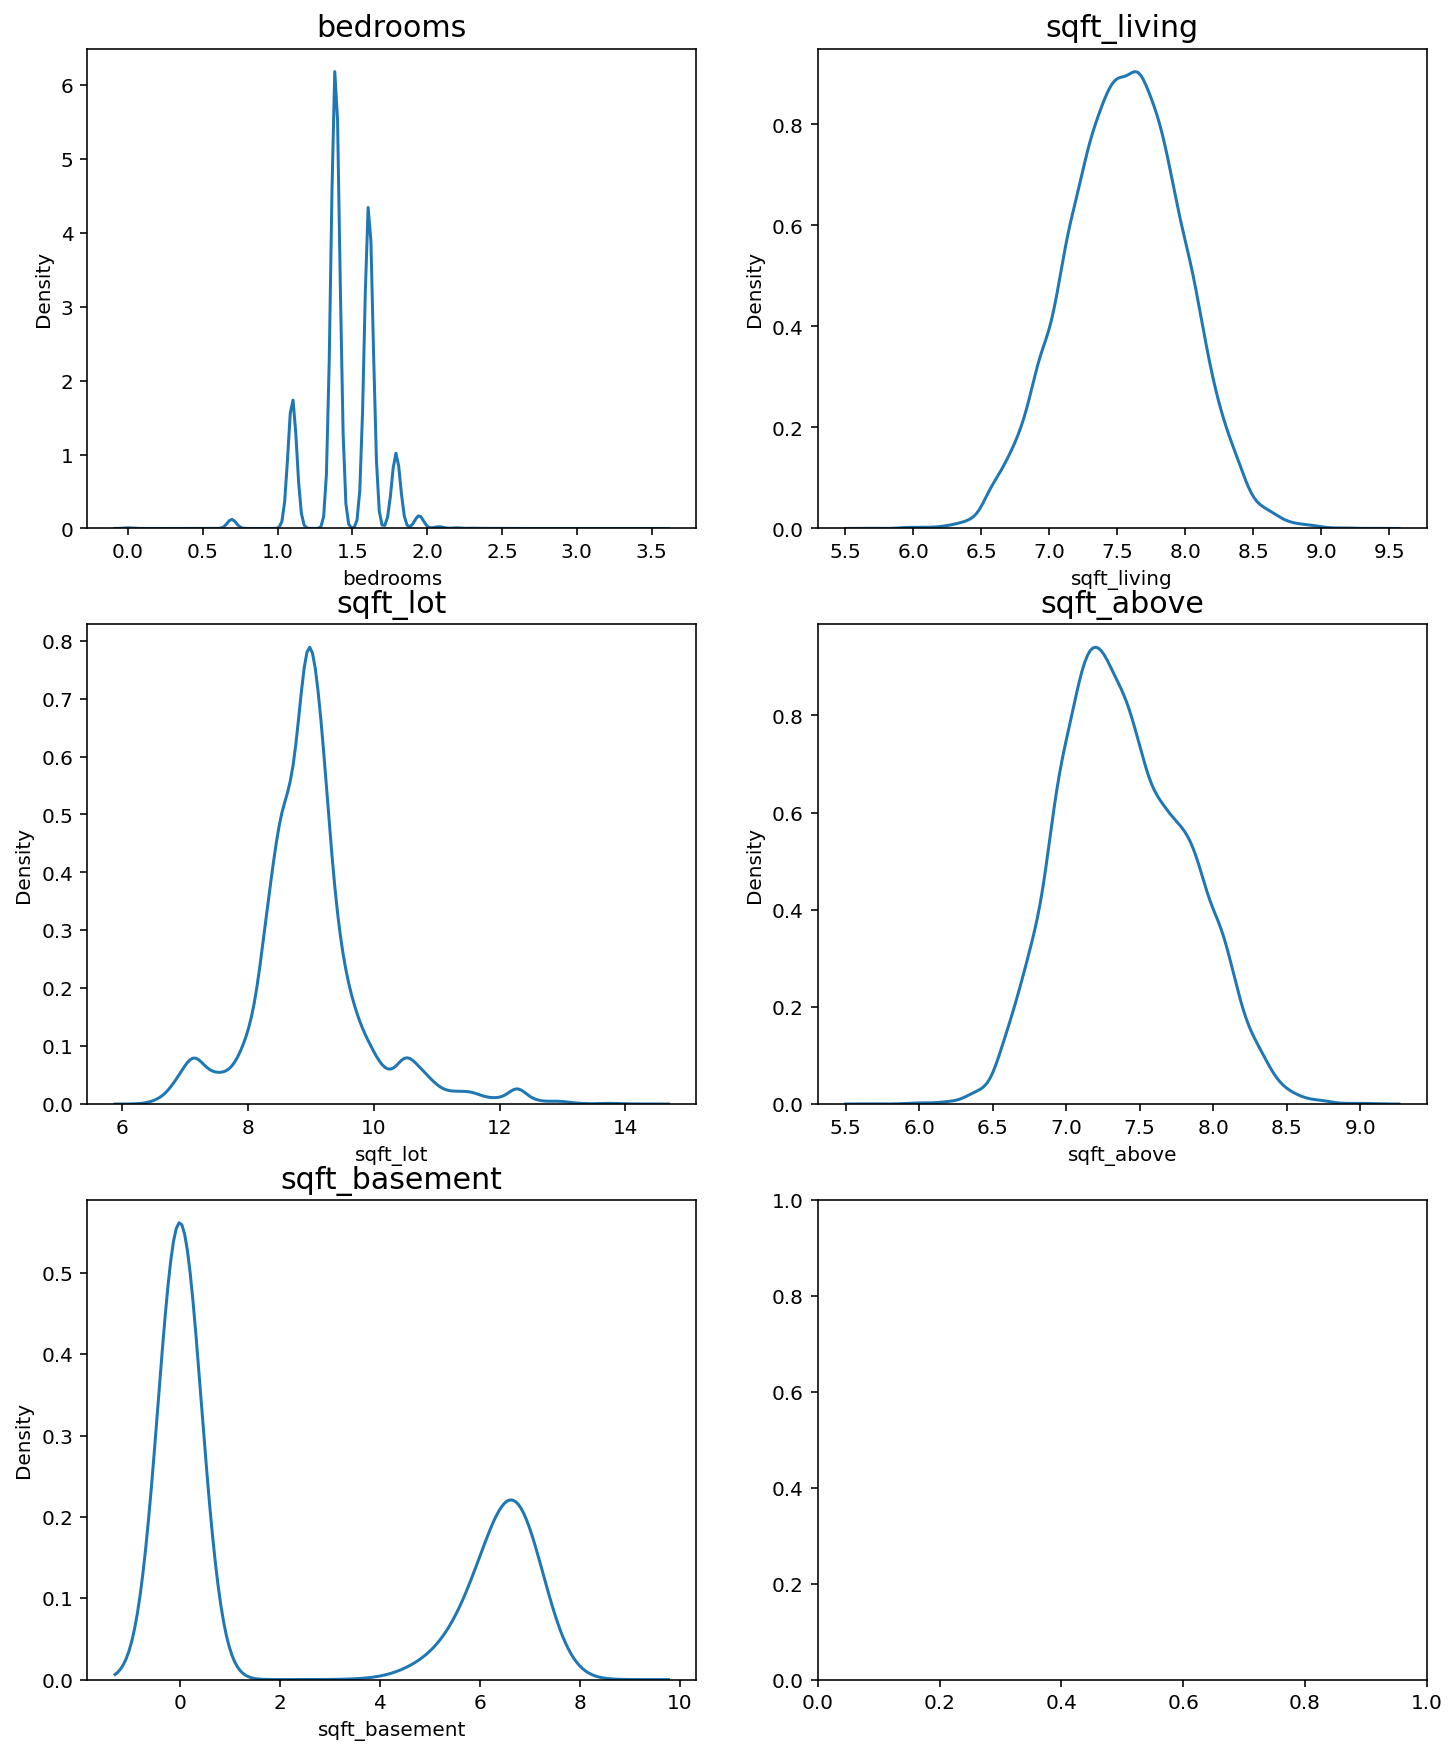

In [35]:
fig, ax = plt.subplots(3, 2, figsize=(12, 15))

count = 0
for row in range(3):
    for col in range(2):
        sns.kdeplot(data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1
        if count == 5:
            break

위에 저장하였던 train_len 인덱스를 이용해 다시 train, test 데이터로 저장해준다.

In [36]:
df_test = data.iloc[train_len:, :] # sub = [15035:21502, 0:19]
df_train = data.iloc[:train_len, :]  # x = [0:15034, 0:19]

print(df_train.shape)  ## id, price 컬럼 제외
print(df_test.shape)  ## id 컬럼 제외

(15031, 20)
(6468, 20)


### 새로운 변수 생성

In [37]:
for df in [df_train, df_test]:
    # 방의 전체 갯수(화장실 포함)
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 주거공간 비율 : 주거공간 / 전체공간(부지)
    df['sqft_living_ration'] = df['sqft_living'] / df['sqft_lot']
    
    # 전체 면적 : 지상 + 지하실
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement'] + df['sqft_lot']
    df['sqft_total_size15'] = df['sqft_living15'] + df['sqft_lot15']  # 인근지역 15개 전체 면적 평균값
    
    # 전체 면적 대비 주거공간 비율
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_total_size']  # 준공 시점 기준
    
    # 집 주변 15개 가구의 주거공간 공간 비율(평균)    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15']  
  
    # 등급 합계
    df['sum_level'] = df['grade'] + df['view'] + df['condition'] 

    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

__zipcode__

In [38]:
df_train['zipcode'].head()

0    98178
1    98028
2    98074
3    98003
4    98198
Name: zipcode, dtype: int64

- 미국의 우편번호는 5자리로 되어 있다.
- 우편번호 체계를 확인해보닌 980XX, 981XX으로 시작하는 지역은 시애틀 지역임을 알수 있었다.  

In [39]:
for df in [df_train, df_test]:
    # 숫자를 문자열로 바꿔주기
    df['zipcode'] = df['zipcode'].astype(str)
    # 컬럼으로 쪼개기
    df['zipcode_front'] = df['zipcode'].str[0:3]
    df['zipcode_end'] = df['zipcode'].str[2:5]

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# zipcode LabelEncoding
for df in [df_train, df_test]:
    le = LabelEncoder()
    df['zipcode'] = le.fit_transform(df['zipcode'])
    df['zipcode_front'] = le.fit_transform(df['zipcode_front'])
    df['zipcode_end'] = le.fit_transform(df['zipcode_end'])

In [40]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15031 entries, 0 to 15034
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                15031 non-null  int64  
 1   bedrooms            15031 non-null  float64
 2   bathrooms           15031 non-null  float64
 3   sqft_living         15031 non-null  float64
 4   sqft_lot            15031 non-null  float64
 5   floors              15031 non-null  float64
 6   waterfront          15031 non-null  int64  
 7   view                15031 non-null  int64  
 8   condition           15031 non-null  int64  
 9   grade               15031 non-null  int64  
 10  sqft_above          15031 non-null  float64
 11  sqft_basement       15031 non-null  float64
 12  yr_built            15031 non-null  int64  
 13  yr_renovated        15031 non-null  float64
 14  zipcode             15031 non-null  int64  
 15  lat                 15031 non-null  float64
 16  long

In [41]:
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,total_rooms,sqft_living_ration,sqft_total_size,sqft_total_size15,sqft_ratio,sqft_ratio15,sum_level,is_renovated,zipcode_front,zipcode_end
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,2.386294,0.818803,15.713705,6990,0.450188,0.237168,10,0,1,66
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,2.098612,0.721756,15.858129,10782,0.419198,0.337385,9,0,0,16
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,3.386294,0.825489,16.424415,9303,0.452201,0.239904,11,0,0,37
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,3.636294,0.843688,16.275366,9057,0.457609,0.328201,10,0,0,2
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,2.886294,0.758837,16.148085,11361,0.431442,0.169910,10,0,1,68


<AxesSubplot:xlabel='long', ylabel='lat'>

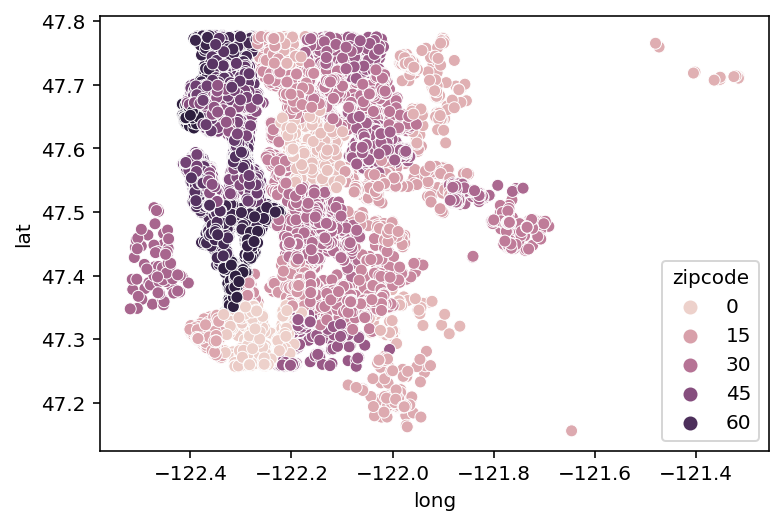

In [42]:
sns.scatterplot(data=df_train, x='long', y='lat', hue='zipcode', hue_order = np.sort(df_train['zipcode'].unique()))

<AxesSubplot:xlabel='long', ylabel='lat'>

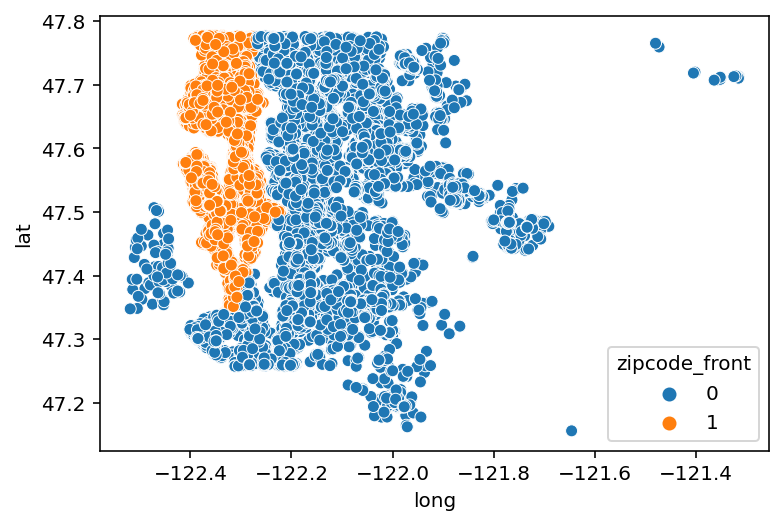

In [43]:
sns.scatterplot(data=df_train, x='long', y='lat', hue='zipcode_front', hue_order = np.sort(df_train['zipcode_front'].unique()))

In [44]:
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,total_rooms,sqft_living_ration,sqft_total_size,sqft_total_size15,sqft_ratio,sqft_ratio15,sum_level,is_renovated,zipcode_front,zipcode_end
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,2.386294,0.818803,15.713705,6990,0.450188,0.237168,10,0,1,66
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,2.098612,0.721756,15.858129,10782,0.419198,0.337385,9,0,0,16
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,3.386294,0.825489,16.424415,9303,0.452201,0.239904,11,0,0,37
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,3.636294,0.843688,16.275366,9057,0.457609,0.328201,10,0,0,2
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,2.886294,0.758837,16.148085,11361,0.431442,0.169910,10,0,1,68


In [45]:
df_test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,total_rooms,sqft_living_ration,sqft_total_size,sqft_total_size15,sqft_ratio,sqft_ratio15,sum_level,is_renovated,zipcode_front,zipcode_end
0,201412,1.386294,2.25,7.852050,8.887791,2.0,0,0,3,7,...,3.636294,0.883465,22.564695,9329,0.347979,0.221233,10,1,1,55
1,201412,1.609438,3.00,7.581210,8.517393,1.0,0,0,5,7,...,4.609438,0.890086,22.289433,6360,0.340126,0.272000,12,0,1,58
2,201405,1.609438,4.50,8.598036,11.532051,1.0,0,0,3,11,...,6.109438,0.745577,27.132149,106690,0.316895,0.046699,14,0,0,29
3,201504,1.386294,1.00,7.484930,8.918784,1.0,0,0,3,7,...,2.386294,0.839232,22.470695,9893,0.333097,0.219401,10,0,1,60
4,201503,1.386294,2.50,7.544861,8.788898,2.0,0,0,3,7,...,3.886294,0.858454,16.333759,9960,0.461918,0.315720,10,0,0,23


In [46]:
# for df in [df_train, df_test]:
#     # 문자열을 다시 숫자로 바꿔주기
#     df['zipcode'] = df['zipcode'].astype(int)
#     df['zipcode_front'] = df['zipcode_front'].astype(int)
#     df['zipcode_end'] = df['zipcode_end'].astype(int)

__lat, long__

In [47]:
# pca for lat, long
for df in [df_train, df_test]:
    coord = df[['lat','long']]
    pca = PCA(n_components=2)
    pca.fit(coord)

    coord_pca = pca.transform(coord)

    df['coord_pca1'] = coord_pca[:, 0]
    df['coord_pca2'] = coord_pca[:, 1]

In [48]:
df_train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_total_size,sqft_total_size15,sqft_ratio,sqft_ratio15,sum_level,is_renovated,zipcode_front,zipcode_end,coord_pca1,coord_pca2
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,...,15.713705,6990,0.450188,0.237168,10,0,1,66,-0.000971,-0.065759
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,...,15.858129,10782,0.419198,0.337385,9,0,0,16,-0.129255,0.122688
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,...,16.424415,9303,0.452201,0.239904,11,0,0,37,0.092459,0.151879
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,...,16.275366,9057,0.457609,0.328201,10,0,0,2,0.075929,-0.264728
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,...,16.148085,11361,0.431442,0.169910,10,0,1,68,0.020549,-0.180840


<AxesSubplot:xlabel='coord_pca2', ylabel='coord_pca1'>

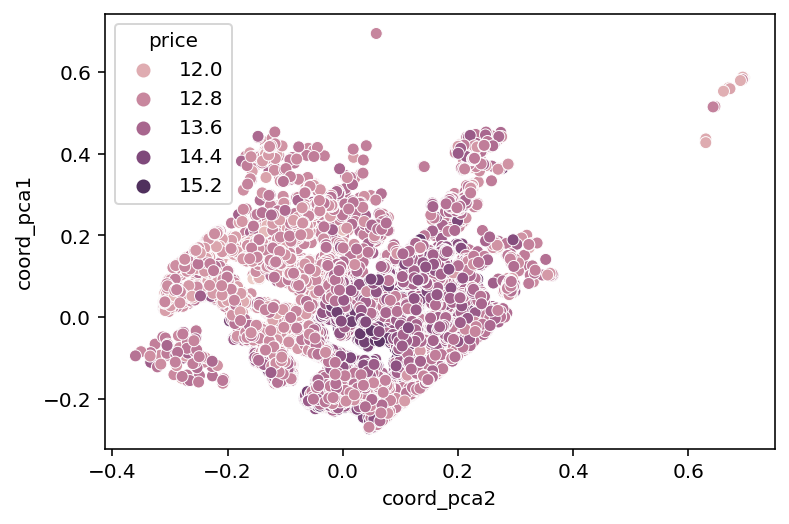

In [49]:
sns.scatterplot(data=df_train, x='coord_pca2', y='coord_pca1', hue=target)

In [50]:
df_train['per_price'] = target / df_train['sqft_total_size']

In [51]:
# zipcode 그룹으로 평균값 산정. 이때 15변수를 써줘야 예측력이 올라갑니다.
df_train['per_price15'] = target / df_train['sqft_total_size15']
zipcode_price = df_train.groupby(['zipcode'])['per_price15'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train, zipcode_price, how='left', on='zipcode')
df_test = pd.merge(df_test, zipcode_price, how='left', on='zipcode')

for df in [df_train,df_test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size15']
    df['zipcode_var'] = df['var'] * df['sqft_total_size15']
    del df['mean']; del df['var']

In [52]:
del df_train['per_price']
del df_train['per_price15']

In [53]:
print(df_train.shape)

(15031, 34)


In [54]:
print(df_test.shape)

(6468, 34)


## 모델 설계

### RMSE 계산

In [55]:
from sklearn.model_selection import train_test_split  # 데이터셋 분리(train, valid)
from sklearn.metrics import mean_squared_error  # RMSE 점수 계산

한 가지 주의해야 할 것은, y_test나 y_pred는 위에서 np.log1p()로 변환이 된 값이기 때문에 원래 데이터의 단위에 맞게 되돌리기 위해 np.expm1()을 추가해야 한다는 점입니다.  

In [56]:
# exp로 다시 변환해서 mean_squared_error를 계산한 값에 np.sqrt를 취하면 RMSE 값을 얻을 수 있겠죠!

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [57]:
# 사용할 모델 불러오기
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [58]:
# random_state는 모델초기화나 데이터셋 구성에 사용되는 랜덤 시드값입니다. 
# random_state=None    # 이게 초기값입니다. 아무것도 지정하지 않고 None을 넘겨주면 모델 내부에서 임의로 선택합니다.  
random_state=2020      # 하지만 우리는 이렇게 고정값을 세팅해 두겠습니다. 

# 사용할 모델 : goobs, xgboost, lightgbm, randomforest
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [59]:
# df_train_columns = [c for c in df_train.columns if c not in ['per_price']]

In [60]:
# 각 모델의 이름은 다음과 같이 클래스의 __name__ 속성에 접근해서 얻을 수 있습니다.
print(gboost.__class__.__name__)
print(xgboost.__class__.__name__)
print(lightgbm.__class__.__name__)
print(rdforest.__class__.__name__)

GradientBoostingRegressor
XGBRegressor
LGBMRegressor
RandomForestRegressor


- get_scores(models, train, y) 함수로 만들어 보겠습니다.
- 다음과 같이 for문 안에서 각 모델 별로 학습 및 예측을 해볼 수 있죠.

In [61]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__
    
        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
    
        # 모델 학습
        model.fit(X_train, y_train)
    
        # 예측
        y_pred = model.predict(X_test)
    
        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
    
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    
    return score_df

In [62]:
get_scores(models, df_train, target)

,RMSE
GradientBoostingRegressor,128340.933590
RandomForestRegressor,120693.228474
XGBRegressor,115802.064996
LGBMRegressor,112486.061343


## 하이퍼 파라미터 실험

실험은 sklearn.model_selection 라이브러리 안에 있는 GridSearchCV 클래스를 활용

- param_grid : 탐색할 파라미터의 종류 (딕셔너리로 입력)
- scoring : 모델의 성능을 평가할 지표
- cv : cross validation을 수행하기 위해 train 데이터셋을 나누는 조각의 개수
- verbose : 그리드 탐색을 진행하면서 진행 과정을 출력해서 보여줄 메세지의 양 (숫자가 클수록 더 많은 메세지를 출력합니다.)
- n_jobs : 그리드 탐색을 진행하면서 사용할 CPU의 개수

In [63]:
from sklearn.model_selection import GridSearchCV

GridSearchCV를 이용해서 grid_model 모델을 초기화하고, train과 y 데이터로 모델을 간단히 학습시키면 param_grid 내의 모든 하이퍼 파라미터의 조합에 대해 실험이 완료됩니다.

In [65]:
# 어떤 파라미터 조합일 때 점수가 어떻게 나오게 되는지 확인하기

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):

    # GridSearchCV 모델로 `model`을 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid,
                         scoring='neg_mean_squared_error',
                         cv=5, verbose=verbose, n_jobs=n_jobs)
    
    # 모델을 fitting 합니다.
    grid_model.fit(train, y)
    
    # params, score에 각 조합에 대한 결과를 저장합니다. 
    params = grid_model.cv_results_['params']  # 파라미터 조합
    score = grid_model.cv_results_['mean_test_score']  # 테스트 점수
    
    # 데이터 프레임 생성 후 RMSLE 값 추가하여 정렬
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1 * results['score'])  # 음수 형태의 score 변환하기
    results = results.sort_values('RMSLE', ascending=False)
    
    return results

In [64]:
# 모델 준비, 모델은 LightGBN(lgmb) 사용
model1 = LGBMRegressor(random_state=random_state)
model2 = XGBRegressor(random_state=random_state)

## 모델 학습 및 예측

### LGBMRegreesor GridSearch

In [66]:
# my_GridSearch 함수로 간단한 그리드 탐색
lgb_param = {
    'laerning_rate' : [0.05],
    'n_estimators': [50, 100, 500],
    'max_depth': [-1, 1, 10, 50],
    'objective' : ['regression']
}

my_GridSearch(model1, df_train, target, lgb_param, verbose=2, n_jobs=5)

# 가장 좋은 조합은 max_depth=50, n_estimators=500 입니다.
# 해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:    6.5s
[Parallel(n_jobs=5)]: Done  60 out of  60 | elapsed:   14.0s finished


[LightGBM] [Warning] Unknown parameter: laerning_rate
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,laerning_rate,max_depth,n_estimators,objective,score,RMSLE
3,0.05,1,50,regression,-0.068362,0.261460
4,0.05,1,100,regression,-0.050670,0.225101
5,0.05,1,500,regression,-0.034946,0.186938
0,0.05,-1,50,regression,-0.028449,0.168669
9,0.05,50,50,regression,-0.028449,0.168669
6,0.05,10,50,regression,-0.028434,0.168624
1,0.05,-1,100,regression,-0.026761,0.163588
10,0.05,50,100,regression,-0.026761,0.163588
7,0.05,10,100,regression,-0.026642,0.163224
2,0.05,-1,500,regression,-0.026378,0.162413


In [68]:
# LGBRegressor best paramameter 사용
model1 = LGBMRegressor(learning_rate=0.05, max_depth=50, n_estimators=500, random_state=random_state)
model1.fit(df_train, target)
prediction1 = model1.predict(df_test)
prediction1

array([13.16443891, 13.14825938, 14.06744275, ..., 13.0291773 ,
       12.7227612 , 13.00384053])

In [69]:
prediction1 = np.expm1(prediction1)
prediction1

array([ 521485.62693268,  513116.1094353 , 1286507.79429106, ...,
        455510.98087056,  335292.38355738,  444114.76036039])

LGBMRegressor 만으로는 스코어를 110,000 이하로 낮출 수 없어 XGBResgressor를 활용해 앙상블을 해보기로 했다.

### XGBRegressor

In [67]:
# my_GridSearch 함수로 간단한 그리드 탐색
xgb_param = {
    'laerning_rate' : [0.05],
    'n_estimators': [500],
    'max_depth': [5],
}

my_GridSearch(model2, df_train, target, xgb_param, verbose=2, n_jobs=5)

# 가장 좋은 조합은 max_depth=50, n_estimators=500 입니다.
# 해당 모델로 학습을 해서 예측값인 submission.csv 파일을 만들어서 제출해보겠습니다.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  6.6min remaining:  9.9min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  6.6min finished


[13:37:43] WARNING: ../src/learner.cc:541: 
Parameters: { laerning_rate } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,laerning_rate,max_depth,n_estimators,score,RMSLE
0,0.05,5,500,-0.029295,0.171159


In [70]:
# XGBRegressor best parameters
model2 = XGBRegressor(learning_rate=0.05, max_depth=5, n_estimators=500, random_state=random_state)
model2.fit(df_train, target)
prediction2 = model2.predict(df_test)
prediction2

array([13.149471, 13.059401, 14.136675, ..., 13.100469, 12.703961,
       13.071638], dtype=float32)

In [71]:
prediction2 = np.expm1(prediction2)
prediction2

array([ 513738.34,  469488.2 , 1378731.1 , ...,  489170.6 ,  329047.8 ,
        475268.88], dtype=float32)

### ensemble

In [72]:
prediction = 0.5 * prediction1 + 0.5 * prediction2

In [73]:
data_dir = os.getenv('HOME')+'/aiffel/exploration/E06/kaggle_kakr_housing/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [74]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,5.176120e+05
1,15036,4.913021e+05
2,15037,1.332619e+06
3,15038,3.007723e+05
4,15039,3.663229e+05


In [75]:
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'ensemble', '02')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/aiffel/aiffel/exploration/E06/kaggle_kakr_housing/data/submission_ensemble_RMSLE_02.csv


## 제출결과

![img](https://user-images.githubusercontent.com/83560273/128886746-078d2418-4e5d-40f9-a51b-d22ebf1a05a4.JPG)

## 회고

- __데이터 준비__
    - 다른 사람들의 커널을 참고 했을 때 정확하지 않은 변수 설명들이 있었다. 실제 대회가 아니라 학습하는 과정이라도 다른 사람의 커널을 참고하기 전에 먼저 내 기준으로 변수를 정리해보고 데이터를 살펴 보는 습관을 들이자. 그래도 이해가 잘되지 않는 부분은 디스커션을 통해 확인하는 습관을 기르자
- __데이터 전처리__ 
    - train, test 데이터 전처리 시 concat으로 merge를 하지 않아도 for문을 이용해서 train, test 데이터셋 전처리를 할 수 있다는 사실을 알게 되었다. 
    - zipcode를 활용한 FE 시도가 점수를 낮추는데 상당한 기여를 하였다. 즉, 모델의 학습과 예측에 있어 Feature Engineering이 굉장히 중요하다는 사실을 알게 되었다.
- __하이퍼 파라미터__ 
    - 노드와 풀잎을 통해서 학습했던 grid search를 통해 최적의 하이퍼 파라미터를 찾아 학습에 적용시킬 수 있었다. 하이퍼 파라미터 튜닝만으로도 어느 정도 점수가 떨어지는 부분을 확인하였으나 분명 한계는 있어 보였다.
- __모델 적용__ 
    - 여러 모델의 RMSE를 평가했을 때 LGBMRegressor가 가장 낮아 계속 점수 낮추기를 시도하였으나, 110,000점 밑으로 점수가 떨어지지 않아 추가적으로 XGBRegressor을 학습시킨 뒤 앙상블을 하였더니 점수가 낮아질 수 있었다. 
    - 사실 원리를 잘 몰라서 직관에 의존해 점수를 맞춘 부분이 아쉽다. 

## 참고자료

- EDA 전반 : https://www.kaggle.com/reddust/feat-groupbyzipcode
- zipcode 관련 FE : 'https://www.kaggle.com/reddust/feat-groupbyzipcode'
- 새로운 변수 추가 : 'https://www.kaggle.com/reddust/feat-groupbyzipcode'